In [5]:
#Imports
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/kickstarter_common.csv')

print(df.info())
print(df.describe())

print(df['country'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331368 entries, 0 to 331367
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            331368 non-null  int64 
 1   name          331368 non-null  object
 2   category      331368 non-null  object
 3   subcategory   331368 non-null  object
 4   country       331368 non-null  object
 5   launched      331368 non-null  object
 6   deadline      331368 non-null  object
 7   goal          331368 non-null  int64 
 8   pledged       331368 non-null  int64 
 9   backers       331368 non-null  int64 
 10  state         331368 non-null  object
 11  duration      331368 non-null  int64 
 12  launch_month  331368 non-null  int64 
 13  launch_year   331368 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 35.4+ MB
None
                 id          goal       pledged        backers       duration   
count  3.313680e+05  3.313680e+05  3.313680e+05  331368.000000  

## Step 1: Success Rate Encoding for category and country
We’ll calculate the success rate (proportion of "successful" projects) for each unique value in `category` and `country`, then map these rates back to the DataFrame as new columns. This will give us numerical representations of how successful each category and country tends to be, which we’ll use in clustering.

In [6]:
# Calculate success rate for 'category'
category_success_rate = df.groupby('category')['state'].apply(lambda x: (x == 'Successful').mean())
df['category_success_rate'] = df['category'].map(category_success_rate)

# Calculate success rate for 'country'
country_success_rate = df.groupby('country')['state'].apply(lambda x: (x == 'Successful').mean())
df['country_success_rate'] = df['country'].map(country_success_rate)

# Verify the new columns
print(df[['category', 'category_success_rate', 'country', 'country_success_rate']].head())

       category  category_success_rate        country  country_success_rate
0       Fashion               0.282881  United States              0.418213
1  Film & Video               0.417907  United States              0.418213
2           Art               0.448759  United States              0.418213
3    Technology               0.237907  United States              0.418213
4       Fashion               0.282881  United States              0.418213


## Step 2: Prepare Features for Clustering
For clustering, we need a set of numerical features that define project similarity. We’ll use `goal`, `duration`, `launch_month`, `launch_year`, `category_success_rate`, and `country_success_rate`. Since goal might be skewed, we’ll apply a log transformation to it. We’ll also standardize all features to ensure they’re on the same scale, which is crucial for K-Means clustering.

In [7]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['goal', 'duration', 'launch_month', 'launch_year', 'category_success_rate', 'country_success_rate']

# Apply log transformation to 'goal' (add 1 to avoid log(0))
df['log_goal'] = np.log1p(df['goal'])

# Update features list with log_goal instead of goal
features = ['log_goal', 'duration', 'launch_month', 'launch_year', 'category_success_rate', 'country_success_rate']

# Extract the feature matrix
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the scaled data
print("Scaled features shape:", X_scaled.shape)
print("Sample of scaled features:\n", X_scaled[:5])

Scaled features shape: (331368, 6)
Sample of scaled features:
 [[-1.00497778  0.4750432  -0.73109636 -2.68196008 -1.14254544  0.3597458 ]
 [ 1.62412002  4.25341837 -0.73109636 -2.68196008  0.13302418  0.3597458 ]
 [-3.3239353  -1.96515743 -0.73109636 -2.68196008  0.4244757   0.3597458 ]
 [-2.38737779  3.62368917 -0.73109636 -2.68196008 -1.56741414  0.3597458 ]
 [-0.62008005 -0.39083444 -0.73109636 -2.68196008 -1.14254544  0.3597458 ]]


## Step 3: Perform K-Means Clustering
We’ll use K-Means to cluster the projects. To choose the number of clusters (`k`), we’ll try a range of values and use the elbow method to find a reasonable `k`. Then, we’ll fit the model with the chosen `k` and assign cluster labels to each project.

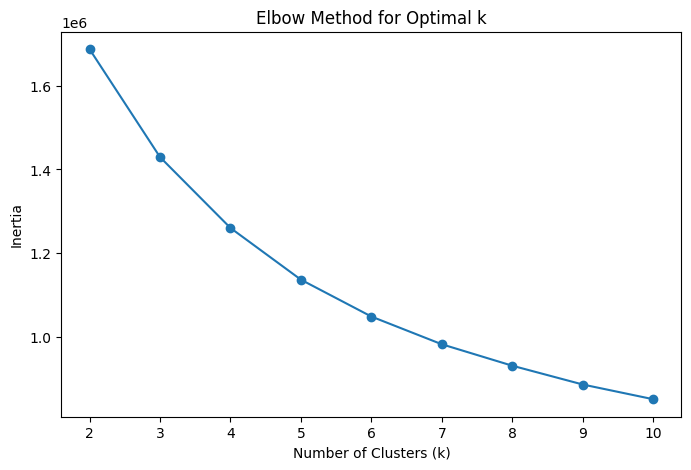

           id      category        country       state  cluster
0  1860890148       Fashion  United States      Failed        3
1   709707365  Film & Video  United States      Failed        0
2  1703704063           Art  United States  Successful        3
3      727286    Technology  United States  Successful        0
4  1622952265       Fashion  United States      Failed        3


In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine optimal k
inertia = []
k_range = range(2, 11)  # Testing k from 2 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose k (e.g., 5) based on the elbow plot and fit the model
k = 5  # Adjust this based on your elbow plot
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Verify cluster assignment
print(df[['id', 'category', 'country', 'state', 'cluster']].head())

## Step 4: Explore Clustering Outcomes
Now that we have cluster labels, let’s explore what they mean. We’ll look at the size of each cluster, the success rate within each cluster, and some summary statistics to understand the groupings.

Cluster sizes:
cluster
1    86472
4    84735
3    81677
0    43857
2    34627
Name: count, dtype: int64

Success rate per cluster:
cluster
0    0.288118
1    0.396209
2    0.298351
3    0.580274
4    0.344509
Name: state, dtype: float64

Summary statistics by cluster:
         log_goal   duration  launch_month  launch_year   
cluster                                                   
0        9.038282  57.727774      6.165242  2013.087740  \
1        8.714980  28.826094      3.281051  2015.129545   
2        8.670476  32.697462      6.736535  2015.587085   
3        7.617987  27.903608      6.757631  2012.744714   
4        9.108736  29.360571      9.292040  2014.580492   

         category_success_rate  country_success_rate  
cluster                                               
0                     0.413012              0.415632  
1                     0.377054              0.416227  
2                     0.372109              0.296523  
3                     0.495819            

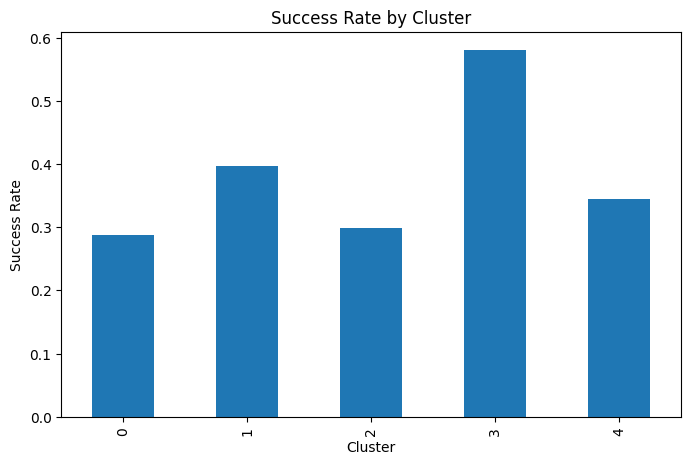

In [9]:
# Cluster sizes
print("Cluster sizes:")
print(df['cluster'].value_counts())

# Success rate per cluster
cluster_success_rate = df.groupby('cluster')['state'].apply(lambda x: (x == 'Successful').mean())
print("\nSuccess rate per cluster:")
print(cluster_success_rate)

# Summary statistics for each cluster
print("\nSummary statistics by cluster:")
cluster_summary = df.groupby('cluster')[features].mean()
print(cluster_summary)

# Optional: Visualize success rate by cluster
cluster_success_rate.plot(kind='bar', figsize=(8, 5))
plt.xlabel('Cluster')
plt.ylabel('Success Rate')
plt.title('Success Rate by Cluster')
plt.show()

# Step 5: Find Closest Projects for a Sample Input
For your goal of providing the 5 closest failed and 5 closest successful projects, let’s simulate a new project input and find its nearest neighbors in the clustered data. We’ll use Euclidean distance on the scaled features.

In [10]:
from sklearn.metrics import pairwise_distances

# Simulate a new project input (example values)
new_project = {
    'goal': 10000,  # $10,000 goal
    'duration': 30,  # 30 days
    'launch_month': 4,  # April
    'launch_year': 2018,
    'category': 'Technology',  # Map to its success rate
    'country': 'United States'  # Map to its success rate
}

# Prepare the new project data
new_project['log_goal'] = np.log1p(new_project['goal'])
new_project['category_success_rate'] = category_success_rate[new_project['category']]
new_project['country_success_rate'] = country_success_rate[new_project['country']]
new_project_data = [new_project['log_goal'], new_project['duration'], new_project['launch_month'],
                    new_project['launch_year'], new_project['category_success_rate'], new_project['country_success_rate']]

# Scale the new project data
new_project_scaled = scaler.transform([new_project_data])


# Calculate distances to all projects
distances = pairwise_distances(new_project_scaled, X_scaled, metric='euclidean').flatten()

# Add distances to the DataFrame
df['distance_to_new'] = distances

# Get 5 closest successful and failed projects
closest_successful = df[df['state'] == 'Successful'].nsmallest(5, 'distance_to_new')
closest_failed = df[df['state'] == 'Failed'].nsmallest(5, 'distance_to_new')

# Get the most distant successful and failed projects
most_distant_successful = df[df['state'] == 'Successful'].nlargest(1, 'distance_to_new')
most_distant_failed = df[df['state'] == 'Failed'].nlargest(1, 'distance_to_new')

# Display results
print("\n5 Closest Successful Projects:")
print(closest_successful[['name', 'category', 'country', 'goal', 'pledged', 'state', 'distance_to_new']])
print("\n5 Closest Failed Projects:")
print(closest_failed[['name', 'category', 'country', 'goal', 'pledged', 'state', 'distance_to_new']])
print("\nMost Distant Successful Project:")
print(most_distant_successful[['name', 'category', 'country', 'goal', 'pledged', 'state', 'distance_to_new']])
print("\nMost Distant Failed Project:")
print(most_distant_failed[['name', 'category', 'country', 'goal', 'pledged', 'state', 'distance_to_new']])




5 Closest Successful Projects:
                                                     name    category   
301292  A Wearable Charging Cable Bracelet That Disrup...  Technology  \
302598            Orion Sun Systems 1000W Solar Generator  Technology   
302721  IllumiBowl: ANTI-GERM Toilet Night Light & 2X ...  Technology   
303315  MODRN MAN Two-Step Skin Care & Grooming System...  Technology   
303749  Antzy Top: An unusual gadget to help you destr...  Technology   

              country   goal  pledged       state  distance_to_new  
301292  United States  10000   134049  Successful         0.523811  
302598  United States  10000    11709  Successful         0.523811  
302721  United States  10000   105280  Successful         0.523811  
303315  United States  10000    10591  Successful         0.523811  
303749  United States  10000    31319  Successful         0.523811  

5 Closest Failed Projects:
                                                     name    category   
300157  iPen: 

## Step 6: Generate Links to the Closest Successful and Failed Projects
After identifying the 5 closest successful and 5 closest failed projects in Step 5 based on clustering and distance, we’ll generate hypothetical Kickstarter links for these projects using their id and a slugified version of their name. This will allow users to explore these similar projects directly.

In [11]:
import urllib.parse

# Function to create a Kickstarter search URL from project name
def create_search_url(project_name):
    # URL-encode the project name to handle spaces and special characters
    encoded_name = urllib.parse.quote(project_name)
    return f"https://www.kickstarter.com/discover/advanced?ref=nav_search&term={encoded_name}"

# Generate search URLs for the closest successful and failed projects
closest_successful["search_link"] = closest_successful["name"].apply(create_search_url)
closest_failed["search_link"] = closest_failed["name"].apply(create_search_url)

# Display results with search links
print("\n5 Closest Successful Projects with Search Links:")
print(closest_successful[['name', 'category', 'country', 'goal', 'pledged', 'state', 'distance_to_new', 'search_link']])
print("\n5 Closest Failed Projects with Search Links:")
print(closest_failed[['name', 'category', 'country', 'goal', 'pledged', 'state', 'distance_to_new', 'search_link']])

# Optional: Display clickable links in Jupyter Notebook
from IPython.display import display, HTML
successful_html = closest_successful[['name', 'search_link']].copy()
successful_html['search_link'] = successful_html['search_link'].apply(lambda x: f'<a href="{x}" target="_blank">{x}</a>')
failed_html = closest_failed[['name', 'search_link']].copy()
failed_html['search_link'] = failed_html['search_link'].apply(lambda x: f'<a href="{x}" target="_blank">{x}</a>')

print("\nClickable Links for Closest Successful Projects:")
display(HTML(successful_html.to_html(escape=False)))
print("\nClickable Links for Closest Failed Projects:")
display(HTML(failed_html.to_html(escape=False)))


5 Closest Successful Projects with Search Links:
                                                     name    category   
301292  A Wearable Charging Cable Bracelet That Disrup...  Technology  \
302598            Orion Sun Systems 1000W Solar Generator  Technology   
302721  IllumiBowl: ANTI-GERM Toilet Night Light & 2X ...  Technology   
303315  MODRN MAN Two-Step Skin Care & Grooming System...  Technology   
303749  Antzy Top: An unusual gadget to help you destr...  Technology   

              country   goal  pledged       state  distance_to_new   
301292  United States  10000   134049  Successful         0.523811  \
302598  United States  10000    11709  Successful         0.523811   
302721  United States  10000   105280  Successful         0.523811   
303315  United States  10000    10591  Successful         0.523811   
303749  United States  10000    31319  Successful         0.523811   

                                              search_link  
301292  https://www.kickstarte

,name,search_link
301292,A Wearable Charging Cable Bracelet That Disrupting The World,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=A%20Wearable%20Charging%20Cable%20Bracelet%20That%20Disrupting%20The%20World
302598,Orion Sun Systems 1000W Solar Generator,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=Orion%20Sun%20Systems%201000W%20Solar%20Generator
302721,IllumiBowl: ANTI-GERM Toilet Night Light & 2X battery Life!,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=IllumiBowl%3A%20ANTI-GERM%20Toilet%20Night%20Light%20%26%202X%20battery%20Life%21
303315,MODRN MAN Two-Step Skin Care & Grooming System for Men,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=MODRN%20MAN%20Two-Step%20Skin%20Care%20%26%20Grooming%20System%20for%20Men
303749,Antzy Top: An unusual gadget to help you destress and focus,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=Antzy%20Top%3A%20An%20unusual%20gadget%20to%20help%20you%20destress%20and%20focus



Clickable Links for Closest Failed Projects:


,name,search_link
300157,iPen: World's first flash drive pen with Lightning connector,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=iPen%3A%20World%27s%20first%20flash%20drive%20pen%20with%20Lightning%20connector
300414,"Plantruth.com, a healthcare insurance ratings website.",https://www.kickstarter.com/discover/advanced?ref=nav_search&term=Plantruth.com%2C%20a%20healthcare%20insurance%20ratings%20website.
300591,FLOWE.green's WooD™ Project.,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=FLOWE.green%27s%20WooD%E2%84%A2%20Project.
300608,The Girl With The Magic Tummy,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=The%20Girl%20With%20The%20Magic%20Tummy
301144,HITGRIP improve your game with the ultimate hitting tool,https://www.kickstarter.com/discover/advanced?ref=nav_search&term=HITGRIP%20improve%20your%20game%20with%20the%20ultimate%20hitting%20tool


In [16]:
import joblib

# Save the scaler
joblib.dump(scaler, '../model/cluster_scaler.joblib')

# Save category and country success rates (if not precomputed elsewhere)
import pickle
with open('../model/category_success_rate.pkl', 'wb') as f:
    pickle.dump(category_success_rate, f)
with open('../model/country_success_rate.pkl', 'wb') as f:
    pickle.dump(country_success_rate, f)
    
df.to_csv('../data/kickstarter_cluster_data.csv', index=False)